In [18]:
%%HTML
<link rel="stylesheet" href="presentazione.css" type="text/css" />

In [11]:
import os
import numpy as np
import pandas as pd
import locale
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')

locale.setlocale(locale.LC_TIME, 'it_IT.utf8')

pd.set_option('display.max_rows', 5)

<div class="logo-container">
    <img class="uni-logo" src="imgs/presentazione/pollo.jpg"/>
    <span class="testatina">Università degli Studi di Udine</span>
</div>


    
Progetto di Fondamenti di Scienze dei Dati
    
# Analisi dei corrispettivi dell'azienda *Là di Cjastelan*
    
Dario Gaudiuso - 15 luglio 2025

# Introduzione

## L'azienda

<img src="imgs/presentazione/logo.png" id="logo">

- Piccola azienda agricola di S. Osvaldo, Udine a conduzione famigliare
- In attività storicamente dal 1870, dal 2007 nella forma attuale

### I prodotti

<ul id="prodotti-carousel">
    <li class="reset">
        <img src="imgs/presentazione/budino-cioccolato.jpeg" />
        <img src="imgs/presentazione/yogurt.JPG" />
    </li>
    <li class="reset">
        <img src="imgs/presentazione/cac_peperoncino2.JPG" />
        <img src="imgs/presentazione/salame.jpeg" />
    </li>
    <li class="reset">
        <img src="imgs/presentazione/mozzarella.jpeg" />
        <img src="imgs/presentazione/carne_maiale.jpeg" />
    </li>
    <li class="reset">
        <img src="imgs/presentazione/salsiccia.jpeg" />
        <img src="imgs/presentazione/ricotta.JPG" />
    </li>
</ul>

### I mercati

<img src="imgs/presentazione/bancarella.jpeg" id="img-bancarella"/>


### e le persone

<img src="imgs/presentazione/trattori.jpeg" />

## I dati

### I corrispettivi

L'Agenzia delle Entrate richiede che ogni trimestre venga consegnata un'autocertificazione riguardo **i corrispettivi** dei registratori di cassa telematici.

**Per ogni cassa** usata dall'azienda, bisogna dichiarare **per ogni giorno** il **totale** incassato in **ciascuna categoria di aliquota IVA**.

I prodotti venduti dall'azienda ricadono in **4 categorie**:
- **IVA 4%** -> Prodotti agricoli (latte, latticini e formaggi)
- **IVA 10% agricola** -> Carne, insaccati e yogurt
- **IVA 10% commerciale** -> Trasformati (gelato, budini, dessert, frico, tortelli, ragù...)
- **IVA 22%** -> Beni non agricoli (buste, confezioni...)

### Come sono raccolti i corrispettivi

<div class="reset" id="corrispettivo-wrapper">
    <div class="reset col1">
        <img class="reset" src="imgs/presentazione/corrispettivo.jpeg">
        <a href="https://www.flaticon.com/free-icons/cow" title="cow icons">Cow icons created by surang - Flaticon</a>
    </div>

  <ul class="reset">
      <li>fino al <strong>2017</strong> una singola persona compilava un'<strong>autodichiarazione cartacea</strong>, sommando manualmente tutti gli scontrini</li>
      <li>da <strong>gennaio 2018</strong> ad <strong>aprile 2024</strong> l'autodichiarazione viene consegnata in <i>pdf</i>, esportando <strong>fogli elettronici</strong> (Excel) in cui vengono ricopiati manualmente i corrispettivi da una singola persona</li>
  </ul>
</div>



da **aprile 2024** a oggi si esporta sempre il solito modello Excel, ma con l'ausilio di un **Google Form**, compilato da chi ha svolto il mercato (il processo però **resta manuale**)

<img src="imgs/presentazione/gform.jpeg" id="img-gform" />

### I reparti

Sono suddivisioni del corrispettivo decise internamente dall'azienda. Nel nostro caso, tutte le casse hanno gli stessi **5 reparti**:
- **Reparto 1** -> Formaggi e latticini
- **Reparto 2** -> Carne e insaccati
- **Reparto 3** -> Yogurt
- **Reparto 4** -> Trasformati
- **Reparto 5** -> Altro (non agricolo)

### Perché studiarli?

Studiare i corrispettivi giornalieri, nella forma in cui sono raccolti, ci permetterebbe di indagare l'**andamento complessivo dell'azienda**, rispondendo a domande come:
1. L'azienda è in crescita o meno?
2. C'è stagionalità nelle vendite, cioè ci sono periodi in cui si vende meglio?
3. Quali prodotti portano più entrate?

Da **aprile 2024** abbiamo anche disponibile l'informazione su **ciascun mercato**, il che, oltre a permetterci di studiare le caratteristiche dei mercati stessi, ci permette di fare **analisi comparate** per capire se:

4. Ci sono mercati che vanno meglio degli altri?
5. Ci sono prodotti che si vendono meglio su un mercato, rispetto agli altri?

# Importazione e pulizia dei dati

## Materiale di partenza

### Cosa è stato consegnato

I dati originali sono stati consegnati in **due forme**:
- una decina di file Excel
- un link a un foglio risposte Google nel Google Drive dell'azienda

I **fogli Excel** coprono tutto l'arco **dal 2018 al primo trimestre del 2025**, ma manca il file dell'ultimo trimestre del 2024.

Il **foglio risposte** registra tutti i corrispettivi da **aprile 2024 a oggi**.

### Fogli Excel

I file sono formati da diversi fogli, uno per mese.

Alcuni file raccolgono i corrispettivi di un intero anno solare (12 fogli, dal 2018 al 2023), altri invece sono organizzati per trimestri dello stesso anno (3 fogli, dal 2024 in poi).

<img src="imgs/presentazione/modello.png" id="img-modello"/>

### Struttura dei fogli Excel

Sebbene l'idea di base sia rimasta la medesima, di fatto **la struttura dei fogli cambia** leggermente sia di file in file, che tra i fogli di uno stesso file.

Questo, per esempio, è il file del **2018**:
<img src="imgs/presentazione/2018.png" />

Questo invece è il file del primo trimestre del **2025**:
<img src="imgs/presentazione/2025.png" />

### Foglio risposte

<img src="imgs/presentazione/foglio-risposte.png" id="img-foglio-risposte" />

## Importazione

### Che forma dare ai dati?

Riuniamo tutti i dati in un unico *dataframe*, conservando l'informazione a **grana più fine**, cioè tenendo sulle colonne i reparti e non l'IVA.

Sulle **colonne** usiamo un _MultiIndex_ che associa a ciacuna delle 3 casse i propri 5 reparti.

Come **indice** usiamo un *DateTimeIndex* con la data del giorno del corrispettivo.

**Non** importiamo i **totali**:
- sono dati derivati
- alcuni sono sicuramente errati
- mancano per i dati più recenti
 

Costruiamo anche un secondo *dataframe* con informazione sui **mercati**, partendo dal foglio risposte.

In questo caso, manteniamo la struttura del file originale, scartando le colonne di controllo e quelle derivate.

Come **colonne** abbiamo quindi cassa, data, mercato e reparti.

In questo _dataframe_, l'indice non è significativo.

### Dati duplicati

I dati **da aprile 2024** in poi sono (quasi tutti) duplicati: esistono in versione "originale" nel foglio risposte e in versione aggregata nei file Excel. Quali dati importiamo?

Inizialmente sembrava più comodo importare direttamente i dati già pronti nei file Excel e costruire solamente i cinque mesi mancanti partendo dal foglio risposte.

Poi in fase di analisi dei mercati sono emersi **errori e incongruenze** nei dati del foglio risposte, che si erano tramandati nei file Excel.

Quindi i fogli Excel sono stati usati solo fino a **marzo 2024**, da lì in poi i corrispettivi sono stati ricostruiti partendo dalla versione pulita e corretta del dataframe del foglio risposte.

### Pulizia dei dati del foglio risposte

L'integrità dei dati è stata controllata facendo, in ordine, questi controlli:

1. corrispettivi duplicati (anche inseriti come mercati diversi)
2. date scritte in modo sbagliato
3. date incoerenti:
    - scontrini "del futuro": la data inserita dall'utente è successiva al timestamp dell'inserimento
    - mercati impossibili: corrispettivi associati a giorni in cui non c'è il mercato a cui si riferiscono (ma potrebbe essere perché è stato spostato il mercato)
4. vincolo di chiave primaria cassa-mercato
5. totale disallineato con la colonna di controllo
6. verifiche puntuali fatte in fase di analisi

In totale sono state corrette 46 entry su 461 (quasi il 10%)

### Processo di importazione

Per il *dataframe* dei corrispettivi, il processo di importazione è stato sostanzialmente:
- costruire la data completa, ricavando anno e mese dai nomi dei file e dei fogli
- mappare le colonne dei file Excel con i giusti reparti
- aggiungere i dati mancanti prendendoli dal _dataframe_ dei mercati
- eliminare le righe vuote (cioè i giorni senza mercati)
- creare l'indice e ordinarlo

Le principali **difficoltà** affrontate sono state:
- colonne con lo stesso nome ma con significato diverso (per esempio le colonne `IVA 10`)
- mutamento del nome delle colonne
- ordine delle colonne non rigido
- Presenza desultoria della multicolonna `Cassa 3`

## Risultato finale

*Dataframe* dei corrispettivi:

In [8]:
corrispettivi = pd.read_pickle(os.path.join('.', 'data', 'corrispettivi_clean.pickle'))
display(corrispettivi)

Cassa 1                                           Cassa 2  \
           Reparto 1 Reparto 2 Reparto 3 Reparto 4 Reparto 5 Reparto 1   
Data                                                                     
2018-01-02    267.02     57.07       0.0       0.0       0.0      0.00   
2018-01-03    161.85     74.85       0.0       0.0       0.0      0.00   
...              ...       ...       ...       ...       ...       ...   
2025-05-29    104.84     57.62      40.0      20.0       0.0    145.00   
2025-05-31    331.05     35.70       5.1      31.0       0.0    395.83   

                                                     Cassa 3            \
           Reparto 2 Reparto 3 Reparto 4 Reparto 5 Reparto 1 Reparto 2   
Data                                                                     
2018-01-02      0.00      0.00       0.0       0.0       0.0       0.0   
2018-01-03      0.00      0.00       0.0       0.0       0.0       0.0   
...              ...       ...       ...       ...       ...       ...   
2025-05-29     55.84     13.65      14.2       0.0       0.0       0.0   
2025-05-31     22.10     30.25      34.2       0.0       0.0       0.0   

                                          
           Reparto 3 Reparto 4 Reparto 5  
Data                                      
2018-01-02       0.0       0.0       0.0  
2018-01-03       0.0       0.0       0.0  
...              ...       ...       ...  
2025-05-29       0.0       0.0       0.0  
2025-05-31       0.0       0.0       0.0  

[2118 rows x 15 columns]

*Dataframe* dei mercati:

In [9]:
mercati = pd.read_pickle(os.path.join('.', 'data', 'web_clean.pickle'))
display(mercati)

,Data,Cassa,Mercato,Reparto 1,Reparto 2,Reparto 3,Reparto 4,Reparto 5
0,2024-04-02,Cassa 2,Centro - Martedì,116.90,46.00,3.3,7.23,NaN
1,2024-04-02,Cassa 1,Passons - Martedì,150.97,14.07,20.6,41.74,NaN
...,...,...,...,...,...,...,...,...
459,2025-06-10,Cassa 2,Passons - Martedì,132.22,31.57,32.4,39.70,NaN
460,2025-06-11,Cassa 2,Villaggio - Mercoledì,240.02,26.54,27.1,NaN,NaN


# Analisi

## I corrispettivi

<Axes: xlabel='Data'>

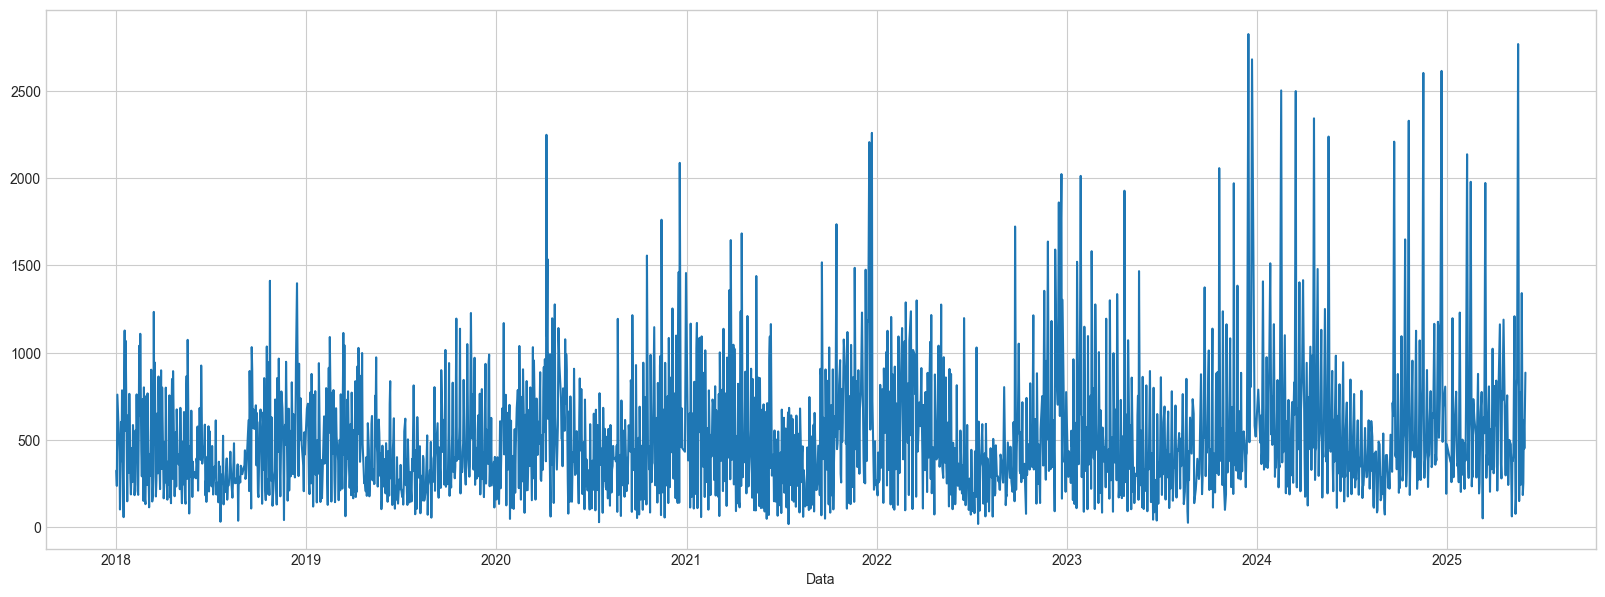

In [20]:
corrispettivi_tot = corrispettivi.sum(axis=1)
corrispettivi_tot

plt.figure(figsize=(20, 7))
sns.lineplot(corrispettivi_tot)

In [ ]:
sns.lineplot